In [ ]:
!pip install backtrader

In [37]:
import sys
sys.path.append("/ibkr")

import os
import datetime
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


import passwords
from databaseClass import DB
from utils import generate_df_from_sql_file, generate_list_from_sql_file
from utils import DataProcessor, ModelBuilder, Predictor
pd.set_option('display.max_rows', None)

In [38]:
userName = passwords.userName
userPass = passwords.userPass
dataBaseName = passwords.dataBaseName
host = passwords.host

db = DB(userName=userName, userPass=userPass, dataBaseName=dataBaseName, host='ibkr_db', docker=True)

In [39]:
input_sql_file='../sql_files/test.sql'
df = generate_df_from_sql_file(input_sql_file, db)

/ibkr/databaseClass.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)


In [40]:
df = df.iloc[1:]
df.head()

,ticktype,price,volume,timestamp
1,1,4363.50,0,2023-06-12 16:36:40.089188
2,2,4363.75,0,2023-06-12 16:36:40.106197
3,4,4363.75,0,2023-06-12 16:36:40.112691
4,5,0.00,2,2023-06-12 16:36:40.118582
5,5,0.00,2,2023-06-12 16:36:40.124512


In [22]:
def process_df(df, look_ahead=5):
    # Create a DataProcessor instance
    processor = DataProcessor(df) 
    # Process the df
    processor.process_df()
    # Scale and shift the data
    scaler, close_scaler = processor.scale_shift_data(look_ahead)
    # Create the X and y datasets
    X, y = processor.scaled_df, processor.shifted_df['Close']
    # Create train test split
    X_train, X_test, y_train, y_test = processor.create_train_test_split(X, y)
    # Create final train and test datasets
    TIME_STEPS = 60
    X_train, y_train = processor.create_dataset(X_train, y_train, TIME_STEPS)
    X_test, y_test = processor.create_dataset(X_test, y_test, TIME_STEPS)
    # Number of features in the data
    n_features = X_train.shape[2]
    
    # Create a ModelBuilder instance and build the model
    builder = ModelBuilder(n_features, TIME_STEPS)
    # Train the model
    #model, history = builder.train_model(X_train, y_train, X_test, y_test, epochs=5, batch_size=64)
    # Save the model
    
    model_path = '../models/model.h5'
    
    builder.load_model(model_path)
    # Plot loss
    #builder.plot_loss(history)
    # Create a Predictor instance
    predictor = Predictor(builder.model, processor)
    # Predict
    predictions = predictor.predict(look_ahead, TIME_STEPS)
    # Rescale predictions
    rescaled_predictions = predictor.rescale_prediction(predictions)
    return y_test, rescaled_predictions

In [ ]:
y_test,rescaled_predictions = process_df(df, 5)

In [41]:
class Backtester:
    def __init__(self, processed_data, predicted_prices, initial_balance):
        self.data = pd.concat([processed_data, pd.DataFrame({
            'Predicted': predicted_prices,
            'Order': np.zeros(len(processed_data)),
            'Holdings': np.zeros(len(processed_data)),
            'Cash': np.full(len(processed_data), initial_balance),
            'Total': np.full(len(processed_data), initial_balance)
        }, index=processed_data.index)], axis=1).copy()
        self.initial_balance = initial_balance
    
    def run(self):
        position = 0  # -1: short, 0: no position, 1: long
        for i in range(len(self.data) - 1):
            actual_price_now = self.data.iat[i, self.data.columns.get_loc('Actual')]
            predicted_price_now = self.data.iat[i, self.data.columns.get_loc('Predicted')]
            # Buy condition
            if predicted_price_now > actual_price_now and position != 1:
                self.data.iat[i, self.data.columns.get_loc('Order')] = 1
                self.data.iat[i, self.data.columns.get_loc('Cash')] -= actual_price_now
                position = 1
            # Sell condition
            elif predicted_price_now < actual_price_now and position != -1:
                self.data.iat[i, self.data.columns.get_loc('Order')] = -1
                self.data.iat[i, self.data.columns.get_loc('Cash')] += actual_price_now
                position = -1
            self.data.iat[i, self.data.columns.get_loc('Holdings')] = position * actual_price_now
            self.data.iat[i, self.data.columns.get_loc('Total')] = self.data.iat[i, self.data.columns.get_loc('Cash')] + self.data.iat[i, self.data.columns.get_loc('Holdings')]
            # Copy Cash and Holdings to the next row
            self.data.iat[i + 1, self.data.columns.get_loc('Cash')] = self.data.iat[i, self.data.columns.get_loc('Cash')]
            self.data.iat[i + 1, self.data.columns.get_loc('Holdings')] = self.data.iat[i, self.data.columns.get_loc('Holdings')]
        self.data.iat[-1, self.data.columns.get_loc('Total')] = self.data.iat[-1, self.data.columns.get_loc('Cash')] + self.data.iat[-1, self.data.columns.get_loc('Holdings')]
        return self.data

    def calculate_metrics(self):
        total_profit = self.data['Total'].iloc[-1] - self.initial_balance
        num_positive_trades = len(self.data[self.data['Order'] > 0])
        num_negative_trades = len(self.data[self.data['Order'] < 0])
        total_trades = num_positive_trades + num_negative_trades
        win_ratio = num_positive_trades / total_trades if total_trades != 0 else 0
        avg_profit_per_trade = total_profit / total_trades if total_trades != 0 else 0
        return_on_investment = total_profit / self.initial_balance
        daily_returns = self.data['Total'].pct_change().dropna()
        sharpe_ratio = np.sqrt(252) * (daily_returns.mean() / daily_returns.std())
        metrics = {
            'Total Profit': total_profit,
            'Number of Positive Trades': num_positive_trades,
            'Number of Negative Trades': num_negative_trades,
            'Win Ratio': win_ratio,
            'Average Profit per Trade': avg_profit_per_trade,
            'Return on Investment': return_on_investment,
            'Sharpe Ratio': sharpe_ratio,
        }
        return metrics

    def plot_portfolio_values(self):
        fig, ax1 = plt.subplots(figsize=(10, 5))
        color = 'tab:blue'
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Actual Prices', color=color)
        ax1.plot(self.data['Actual'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:red'
        ax2.set_ylabel('Total Value', color=color)
        ax2.plot(self.data['Total'], color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.title('Actual Prices and Portfolio Value Over Time')
        plt.show()

In [42]:
def test_on_unseen_data(unseen_df, model_path, look_ahead, time_steps, initial_balance):
    model = load_model(model_path)
    data_processor = DataProcessor(unseen_df)
    data_processor.process_df()
    data_processor.scale_shift_data(look_ahead)
    X_unseen, y_unseen = data_processor.create_dataset(data_processor.scaled_df, data_processor.shifted_df['Close'], time_steps)
    predictor = Predictor(model, data_processor)
    predictions_unseen = predictor.predict(look_ahead, time_steps)
    rescaled_predictions_unseen = predictor.rescale_prediction(predictions_unseen)
    rescaled_predictions_unseen = rescaled_predictions_unseen.flatten()

    actual_prices_unseen = data_processor.processed_df['Close'].values[time_steps+look_ahead:]
    actual_prices_unseen = actual_prices_unseen.flatten()

    processed_data_unseen = data_processor.processed_df.iloc[time_steps+look_ahead:]
    processed_data_unseen = processed_data_unseen.assign(Actual = actual_prices_unseen)
    backtester = Backtester(processed_data_unseen, rescaled_predictions_unseen, initial_balance)
    results = backtester.run()
    backtester.plot_portfolio_values()
    metrics = backtester.calculate_metrics()
    return results, metrics


/ibkr/databaseClass.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)


695/695 [==============================] - 3s 4ms/step


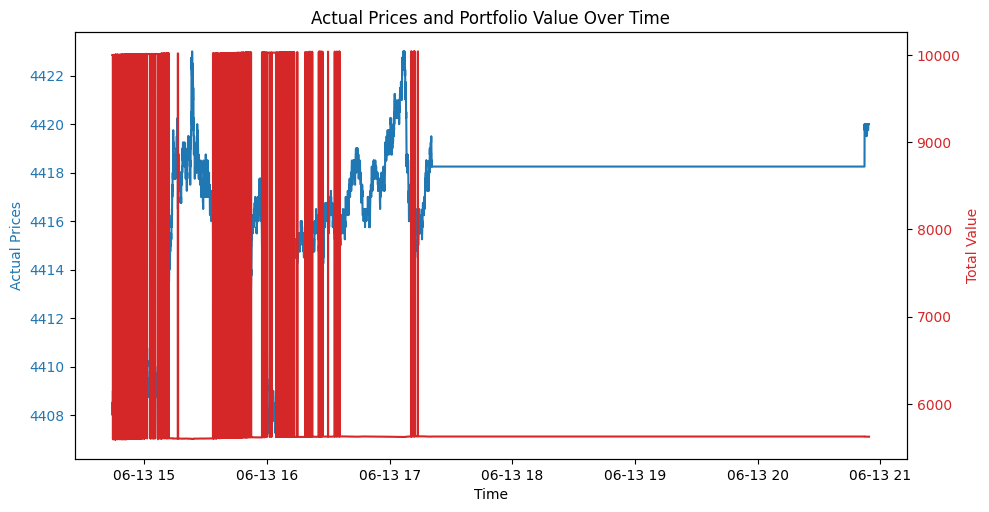

In [43]:
input_sql_file='../sql_files/jun13.sql'
unseen_df = generate_df_from_sql_file(input_sql_file, db)

model_path = "../models/model.h5"  # replace with the actual path to your saved model
look_ahead = 5  # replace with the value you used in training
time_steps = 60  # replace with the value you used in training
initial_balance = 10000
results, metrics = test_on_unseen_data(unseen_df, model_path, look_ahead, time_steps, initial_balance)

In [44]:
results.head(5)

,Open,High,Low,Close,Volume,Actual,Predicted,Order,Holdings,Cash,Total
timestamp,,,,,,,,,,,
2023-06-13 14:44:20,4408.25,4408.50,4408.25,4408.50,2.0,4408.50,4409.347656,1.0,4408.50,5591.5,10000.00
2023-06-13 14:44:21,4408.25,4408.50,4408.25,4408.25,34.0,4408.25,4409.278809,0.0,4408.25,5591.5,9999.75
2023-06-13 14:44:22,4408.25,4408.50,4408.25,4408.25,7.0,4408.25,4409.241699,0.0,4408.25,5591.5,9999.75
2023-06-13 14:44:23,4408.00,4408.25,4408.00,4408.25,26.0,4408.25,4409.192871,0.0,4408.25,5591.5,9999.75
2023-06-13 14:44:24,4408.00,4408.25,4408.00,4408.00,2.0,4408.00,4409.153809,0.0,4408.00,5591.5,9999.50


In [45]:
metrics

{'Total Profit': -4378.5,
 'Number of Positive Trades': 264,
 'Number of Negative Trades': 264,
 'Win Ratio': 0.5,
 'Average Profit per Trade': -8.292613636363637,
 'Return on Investment': -0.43785,
 'Sharpe Ratio': 0.6607976584986581}

In [ ]:
model = load_model(model_path)

In [ ]:
data_processor = DataProcessor(unseen_df)

In [ ]:
data_processor.process_df()

In [ ]:
data_processor.scale_shift_data(look_ahead)

In [ ]:
X_unseen, y_unseen = data_processor.create_dataset(data_processor.scaled_df, data_processor.shifted_df['Close'], time_steps)

In [ ]:
y_unseen

In [ ]:
predictor = Predictor(model, data_processor)
predictions_unseen = predictor.predict(look_ahead, time_steps)
rescaled_predictions_unseen = predictor.rescale_prediction(predictions_unseen)

# Get the actual prices (unnormalized)
actual_prices_unseen = data_processor.processed_df['Close'].values[time_steps+look_ahead:]

# Run the backtester
backtester = Backtester(actual_prices=actual_prices_unseen, predicted_prices=rescaled_predictions_unseen, initial_balance=initial_balance)
profit_unseen = backtester.run()

In [ ]:
actual_prices_unseen